In [411]:
from k_means_constrained import KMeansConstrained
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, LineString, Point

## Creating the delivery Locations

In [412]:
def create_locations(x, y, n):
    loc = []

    for _ in range(n):
        loc_x = random.randint(int(x[0]), int(y[0])) + random.randint(int((x[0] - int(x[0]))*10000), int((y[0] - int(y[0]))*10000)) / 10000
        loc_y = random.randint(int(x[1]), int(y[1])) + random.randint(int((x[1] - int(x[1]))*10000), int((y[1] - int(y[1]))*10000)) / 10000
        loc.append([loc_x,loc_y])
        
    return loc

## Verify delivary locations

In [413]:
def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [414]:
def verify_locations(delivery_loc, obstacles):
    obstacle_polygon = []
    answer = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))
    
    for loc in delivery_loc:
        flag = True
        for obs in obstacle_polygon:
            if Point([loc[0],loc[1]]).intersects(obs):
                flag = False
                break
        if flag:
            answer.append(loc)

    return answer

## Visualizing the data

In [415]:
def initial_plot(delivery_loc, obstacles):
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.7)
    plt.title("Delivery Locations")
    plt.show()

In [416]:
def clusters_plot(clusters, centroids, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]
        
        plt.fill(x,y,color="red", alpha = 0.7)
    plt.title("After Clustering")
    plt.show()

In [417]:
def dp_plot(clusters, centroids, dp, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.scatter(dp[0], dp[1], marker='+',s=200, c="red")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.7)
    plt.title("After DP Creation")
    plt.show()

In [418]:
def final_plot(delivery_loc,clusters, dp, obstacles):
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    deliveries = np.array(delivery_loc)
    plt.scatter(deliveries[:,0], deliveries[:,1])

    for i in clusters:
        pts = np.array(clusters[i])
        # plt.scatter(pts[:,0], pts[:,1])
        #try
        points = pts[1:-1,:]
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.7)
    plt.title("Final Result")
    plt.show()

## KMeans Clustering

In [419]:
def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

## Calculate DP

In [420]:
def calculate_dp(centroids):
    x = [i for i,j in centroids]
    y = [j for i,j in centroids]

    loc_x = np.mean(x)
    loc_y = np.mean(y)

    return [loc_x, loc_y]

## Traveling Salesman Problem

In [421]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [422]:
def total_distance(clusters):
    total = 0
    for i in clusters:
        pts = clusters[i]
        for j in range(len(pts)-1):
            total += calculate_distance(pts[j], pts[j+1])
    
    return total

In [423]:
def is_obstacle_free(line, obstacles):
    for obs in obstacles:
        if line.intersects(obs):
            return False
    return True

In [424]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = obstacles
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle in obstacle_polygons:
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.001
    increment = 0.001
    limit = 1.0

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs in obstacle_polygons:
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs in obstacle_polygons:
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs in obstacle_polygons:
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs in obstacle_polygons:
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

<font color="red">Try</font>

In [425]:
from shapely.affinity import translate

In [426]:
def scale_polygon(polygon, scale_factor = 0.99):
    centroid = polygon.centroid

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [427]:
import networkx as nx

def create_shortest_path(point_1, point_2, obstacles):
    route_line = LineString([point_1, point_2])

    intersections = []
    # for obstacle in obstacles:
    #     for i in range(len(obstacle.exterior.coords) - 1):
    #         start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
    #         line = LineString([start, end])
    #         if route_line.intersects(line):
    #             intersections.append(start)
    #             intersections.append(end)

    for obstacle in obstacles:
        if route_line.intersects(obstacle):
            for cord in range(len(obstacle.exterior.coords)-1):
                intersections.append(obstacle.exterior.coords[cord])

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))
    
    G.add_node(tuple(point_2))

    # create new polygon
    for id,obstacle in enumerate(obstacles):
        obstacles[id] = scale_polygon(obstacle)

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            line = LineString([cur, next])
            if is_obstacle_free(line, obstacles):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=calculate_distance)

    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos, node_color='lightgray', with_labels=True)
    # nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    # nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    # nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    # plt.title('Path Planning with Obstacle Avoidance')
    # plt.show()

    return path

In [428]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle in obstacles:
    if line.intersects(obstacle):
      # intermediate_point = find_inter_point(point_a, point_b, obstacles)
      intermediate_point = create_shortest_path(point_a, point_b, obstacles.copy())
      distance = 0

      for pts in range(len(intermediate_point)-1):
        distance += calculate_distance(intermediate_point[pts], intermediate_point[pts + 1])

      return distance, intermediate_point

  return calculate_distance(point_a, point_b), None

In [429]:
def create_distance_matrix(points,dp,obstacles):
    matrix = {}
    inter_matrix = {}
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    points.append(dp)
    for src in points:
        for dest in points:
            src_point = tuple(src)
            dest_point = tuple(dest)
            distance,inter = check_obstacle_in_line(src_point, dest_point, obstacle_polygon)
            matrix[(src_point, dest_point)] = distance
            if inter != None:
                inter_matrix[(src_point, dest_point)] = inter
    
    return matrix, inter_matrix

In [430]:
from itertools import permutations

def tsp_brut(cluster, dp, obstacles):
    paths = list(permutations(cluster))
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster,dp, obstacles)
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)
        path.append(dp)
        path.insert(0, dp)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_path.append(dp)
    min_path.insert(0,dp)
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    # work end

## Main

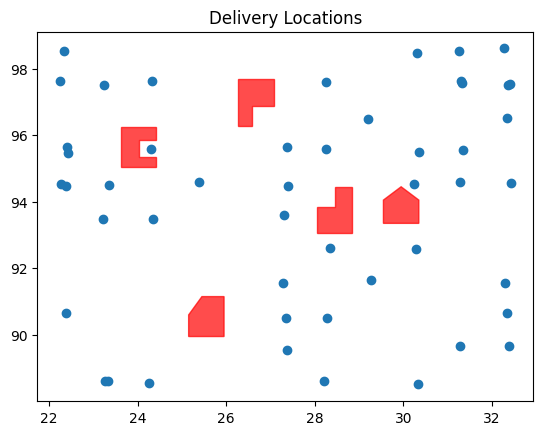

In [431]:
#no of delivery locations and drone capacity
n = 50
k = 6

# creating the boundary
x = [22.21, 88.45]
y = [32.45, 98.67]
delivery_loc = create_locations(x, y, n)

# obstacles
obstacles = {
    0 : [[28.05, 93.05],[28.85, 93.05],[28.85, 94.45], [28.45, 94.45], [28.45, 93.85],[28.05, 93.85],[28.05, 93.05]],
    1 : [[25.15, 89.95],[25.95, 89.95],[25.95, 91.15], [25.45, 91.15], [25.15, 90.60],[25.15, 89.95]],
    2 : [[26.27, 96.29],[26.57, 96.29],[26.57, 96.89], [27.07, 96.89],[27.07, 97.69], [26.27, 97.69], [26.27, 96.29]],
    3 : [[23.62, 95.04],[24.42, 95.04],[24.42, 95.34], [24.02, 95.34], [24.02, 95.84],[24.42, 95.84],[24.42, 96.24],[23.62, 96.24],[23.62, 96.24]],
    4 : [[29.55, 93.35],[30.35, 93.35],[30.35, 94.05], [29.95, 94.45], [29.55, 94.05], [29.55, 93.35]],
}

delivery_loc = verify_locations(delivery_loc, obstacles)

# Visualize the data
initial_plot(delivery_loc, obstacles)

{0: [[32.3812, 89.6573], [31.2727, 89.6525], [30.3379, 88.5098], [32.3021, 91.5605], [32.3307, 90.653]], 1: [[22.4302, 95.4765], [24.3203, 97.6316], [22.3938, 95.6361], [22.2444, 97.6373], [23.2437, 97.5055], [22.3377, 98.5419]], 2: [[28.2462, 95.5782], [30.3097, 98.4746], [28.2439, 97.5876], [29.212, 96.4812], [30.354, 95.4856]], 3: [[28.213, 88.6135], [27.3522, 90.4954], [27.2723, 91.5479], [29.2671, 91.6579], [28.2696, 90.512], [27.3746, 89.5465]], 4: [[23.3588, 94.5165], [23.2229, 93.474], [22.2672, 94.5388], [22.382, 94.4627], [24.3503, 93.4873], [24.3077, 95.5706]], 5: [[31.3216, 97.5635], [32.4193, 97.5242], [31.2964, 97.6239], [32.3571, 97.5131], [31.2591, 98.5329], [32.27, 98.6043]], 6: [[27.3689, 95.6505], [25.3937, 94.5858], [28.3465, 92.6087], [27.2955, 93.6014], [27.3879, 94.4681]], 7: [[30.2487, 94.5455], [30.2874, 92.5821], [32.4303, 94.5554], [32.3388, 96.5253], [31.2689, 94.5912], [31.3565, 95.5544]], 8: [[23.335, 88.6145], [24.2597, 88.5622], [22.3754, 90.6565], [23.2

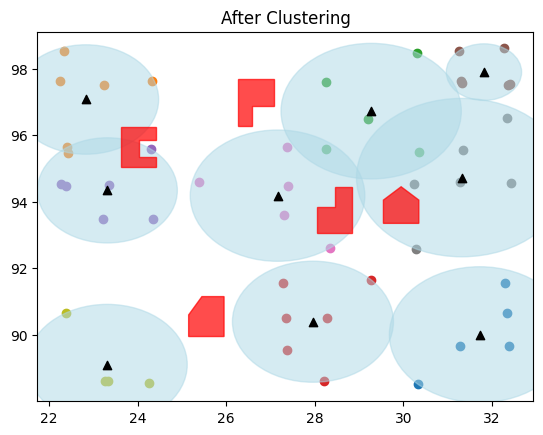

In [432]:
# Cluster the data and get the labels and centroids
centroids, clusters = KMeans(delivery_loc, n, k)

print(clusters)

# Visualize the data
clusters_plot(clusters, centroids, obstacles)

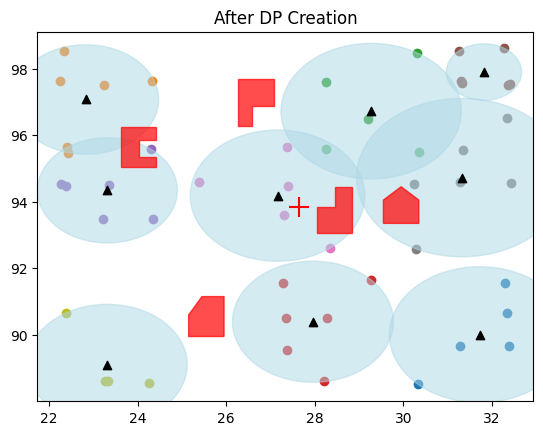

In [433]:
# Calculate DP
DP = calculate_dp(centroids)

# Visualize the data
dp_plot(clusters, centroids, DP, obstacles)

<font color="green">try</font>

In [434]:
def initial_tsp(cluster, dp, method="christofides"):
    
    if method == "christofides":
        path = cluster
        path.append(dp)
        path.insert(0, dp)

        G = nx.Graph()

        for pt in path:
            G.add_node(tuple(pt))

        for i in range(len(path)-1):
            for j in range(i+1,len(path)):
                G.add_edge(tuple(path[i]),tuple(path[j]), weight = calculate_distance(path[i], path[j]))

        path = nx.approximation.traveling_salesman.christofides(G, weight='weight')
    
    elif method == 'brut_force':
        path = list(permutations(cluster))
        cost = []
        # add dp at the start and end
        for i in range(len(path)):
            path[i] = list(path[i])
            path[i].append(dp)
            path[i].insert(0, dp)

            # Calculate distance
            points = path[i]
            sum = 0

            for j in range(len(points)-1):
                sum += calculate_distance(points[j], points[j+1])
            cost.append(sum)

        idx = np.argmin(cost)
        path = path[idx]

    return path

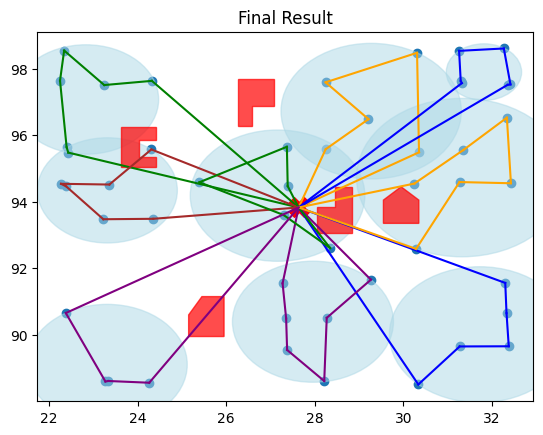

In [435]:
for i in clusters:
    clusters[i] = initial_tsp(clusters[i], DP, method="brut_force")

final_plot(delivery_loc,clusters, DP, obstacles)

In [436]:
initial_distance = total_distance(clusters)
print("Distance using manhattan cluster :",initial_distance)

Distance using manhattan cluster : 121.60651253545446


<font color="green">try</font>

In [437]:
# Shortest path calculation in each cluster
for i in clusters:
    clusters[i] = tsp_brut(clusters[i], DP, obstacles)


Optimal path [[27.634461666666667, 93.82745574074073], [27.634461666666667, 93.82745574074073], [32.3021, 91.5605], [32.3307, 90.653], [32.3812, 89.6573], [31.2727, 89.6525], [30.3379, 88.5098], [27.634461666666667, 93.82745574074073], [27.634461666666667, 93.82745574074073]] optimal distance 15.842171557638387
Optimal path [[27.634461666666667, 93.82745574074073], [27.634461666666667, 93.82745574074073], [22.4302, 95.4765], [22.3938, 95.6361], [22.2444, 97.6373], [22.3377, 98.5419], [23.2437, 97.5055], [24.3203, 97.6316], [27.634461666666667, 93.82745574074073], [27.634461666666667, 93.82745574074073]] optimal distance 16.046642857655925
Optimal path [[27.634461666666667, 93.82745574074073], [27.634461666666667, 93.82745574074073], [28.2462, 95.5782], [29.212, 96.4812], [28.2439, 97.5876], [30.3097, 98.4746], [30.354, 95.4856], [27.634461666666667, 93.82745574074073], [27.634461666666667, 93.82745574074073]] optimal distance 13.07779229935926
Optimal path [[27.634461666666667, 93.8274

In [438]:
for i in clusters:
    print("Path",i,":")
    for j in clusters[i]:
        print(j,"->",end=" ")
    print("End")

Path 0 :
[27.634461666666667, 93.82745574074073] -> [27.634461666666667, 93.82745574074073] -> (28.05, 93.05) -> [32.3021, 91.5605] -> [32.3307, 90.653] -> [32.3812, 89.6573] -> [31.2727, 89.6525] -> [30.3379, 88.5098] -> [27.634461666666667, 93.82745574074073] -> [27.634461666666667, 93.82745574074073] -> End
Path 1 :
[27.634461666666667, 93.82745574074073] -> [27.634461666666667, 93.82745574074073] -> (23.62, 95.04) -> [22.4302, 95.4765] -> [22.3938, 95.6361] -> [22.2444, 97.6373] -> [22.3377, 98.5419] -> [23.2437, 97.5055] -> [24.3203, 97.6316] -> [27.634461666666667, 93.82745574074073] -> [27.634461666666667, 93.82745574074073] -> End
Path 2 :
[27.634461666666667, 93.82745574074073] -> [27.634461666666667, 93.82745574074073] -> [28.2462, 95.5782] -> [29.212, 96.4812] -> [28.2439, 97.5876] -> [30.3097, 98.4746] -> [30.354, 95.4856] -> (28.45, 94.45) -> [27.634461666666667, 93.82745574074073] -> [27.634461666666667, 93.82745574074073] -> End
Path 3 :
[27.634461666666667, 93.827455740

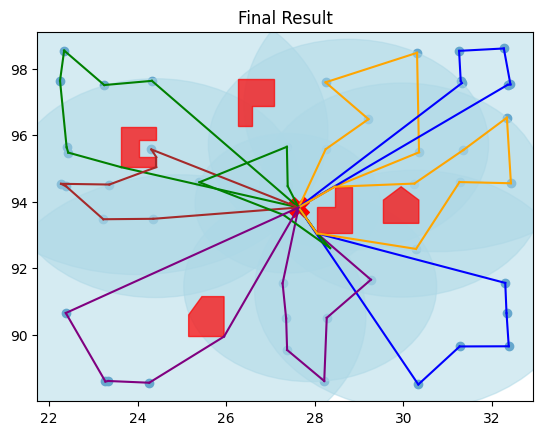

In [439]:
# Final Visualization
final_plot(delivery_loc,clusters, DP, obstacles)

## Calculate Total DIstance

*Total distance in manhattan cluster*

In [440]:
new_distance = total_distance(clusters)
print("Distance using manhattan cluster :",new_distance)

Distance using manhattan cluster : 122.66640336762357


In [441]:
print(initial_distance)
print(new_distance)

121.60651253545446
122.66640336762357


## file handling

In [442]:
import pandas as pd

df = pd.read_csv('./drone_performance_on_obstacles.csv')

new_row = {
    'delivary_locations':n,
    'drone_capacity':k,
    'obstacles':len(obstacles),
    'obstacle_free_distance':initial_distance,
    'with_obstacle_distance':new_distance,
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,obstacle_free_distance,with_obstacle_distance,distance_after_dp_relocation
31,20,5,5,59.490894,59.490894,NaN
32,20,5,5,54.584135,55.651152,NaN
33,20,5,5,56.387633,56.778665,NaN
34,20,5,5,57.715202,58.064866,NaN
35,50,6,5,121.606513,122.666403,NaN


In [443]:
try:
    df.to_csv('./drone_performance_on_obstacles.csv', index=False)
except:
    print("Unknown error occurs")

## Hold

In [444]:
from itertools import permutations

def tsp_brut(cluster, dp):
    path = list(permutations(cluster))
    cost = []
    # add dp at the start and end
    for i in range(len(path)):
        path[i] = list(path[i])
        path[i].append(dp)
        path[i].insert(0, dp)

        # Calculate distance
        points = path[i]
        sum = 0

        for j in range(len(points)-1):
            sum += calculate_distance(points[j], points[j+1])
        cost.append(sum)

    idx = np.argmin(cost)
    return path[idx]

In [445]:
lst = [1.2,2.3,3.4,4.5,5.6,6.7]
paths = list(permutations(lst))
print(list(paths[0]))

[1.2, 2.3, 3.4, 4.5, 5.6, 6.7]


In [446]:
example = {
    2 : "hi",
    3 : "hello"
}

num = 3

if example.get(3):
    print("Exist")

Exist


In [447]:
def final_plot(clusters, dp, obstacles):
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    for i in clusters:
        pts = np.array(clusters[i])
        plt.scatter(pts[:,0], pts[:,1])
        #try
        points = pts[1:-1,:]
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    plt.title("Final Result")
    plt.show()

In [448]:
def edit(sample):
    sample[1] = 'hola'

In [449]:
sample = {
    1 : "hi",
    2 : "hello"
}

edit(sample.copy())

print(sample)

{1: 'hi', 2: 'hello'}


In [450]:
nodes = [(2,2),(3,4),(8,4),(1,4),(7,3)]

G = nx.Graph()

G.add_nodes_from(nodes)

for i in range(len(nodes)-1):
    for j in range(i+1,len(nodes)):
        G.add_edge(nodes[i],nodes[j], weight = 2)

path = nx.approximation.christofides(G)

path

[(2, 2), (1, 4), (8, 4), (7, 3), (3, 4), (2, 2)]